In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split



data = pd.read_csv("R.csv")

2023-06-16 15:32:50.708737: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 15:32:50.752662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 15:32:50.753599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 15:32:51.441683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

features = labels[feature_headings]
labels = labels[[c for c in labels.columns if c not in feature_headings]]


In [3]:
materials = list(set([*features["First Layer"].unique(), *features["Second Layer"].unique()]))

mapping = {
    v: i for (i,v) in enumerate(materials)
}

features["First Layer"] = features["First Layer"].apply(lambda x: mapping[x])
features["Second Layer"] = features["Second Layer"].apply(lambda x: mapping[x])


features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1)


feature_array = np.array(features_train)
feature_array

array([[10, 50, 30, ..., 10, 25, 12],
       [10, 50, 20, ..., 20, 12, 15],
       [50, 10, 30, ..., 60, 28,  5],
       ...,
       [60, 30, 60, ..., 60,  8, 16],
       [60, 50, 50, ..., 60,  6, 25],
       [60, 40, 10, ..., 30,  8, 27]])

In [22]:
ml_model = keras.Sequential([
   
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dropout(.8),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(.8),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(.8),
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dense(len(labels.columns),activation="sigmoid")
])

ml_model.compile(loss= keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())

In [23]:
ml_model.fit(features_train, labels_train, epochs=10, validation_split=0.1)

Epoch 1/10
760/760 [==============================] - 4s 4ms/step - loss: 0.1413 - val_loss: 0.1176
Epoch 2/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1177 - val_loss: 0.1176
Epoch 3/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1176 - val_loss: 0.1176
Epoch 4/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1176 - val_loss: 0.1176
Epoch 5/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1176 - val_loss: 0.1177
Epoch 6/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1176 - val_loss: 0.1176
Epoch 7/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1177 - val_loss: 0.1176
Epoch 8/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1176 - val_loss: 0.1176
Epoch 9/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1177 - val_loss: 0.1176
Epoch 10/10
760/760 [==============================] - 3s 4ms/step - loss: 0.1176 - val_loss: 0.1176

 1/94 [..............................] - ETA: 4s

94/94 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Test data model outputs')

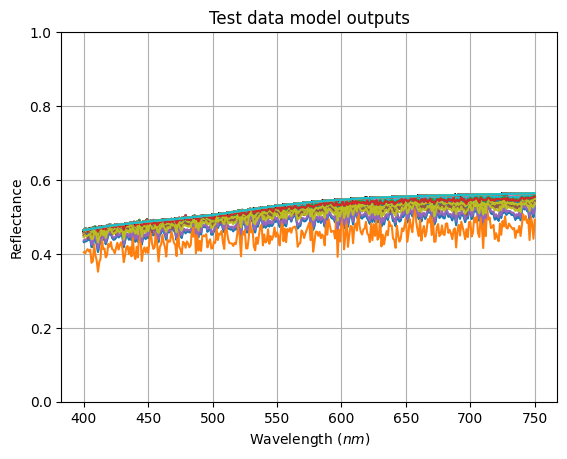

In [30]:
test_output = ml_model.predict(features_test)

residuals = test_output - np.array(labels_test)
avg_residual = [sum(a)/len(a) for a in residuals]
avg_avg_residual = sum(avg_residual)/len(avg_residual)

import matplotlib.pyplot as plt

# pd.Series(avg_residual).plot(kind="kde")
plt.plot(np.arange(400,751), list(zip(*test_output)))
plt.ylim((0,1))

plt.xlabel("Wavelength ($nm$)")
plt.ylabel("Reflectance")
plt.grid()

plt.title("Test data model outputs")

In [26]:
materials_to_use = mapping["Co"], mapping["Co"]

1/1 [==============================] - 0s 52ms/step


/home/clk/repos/l2-transfer-matrix-method/.venv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


(0.0, 1.0)

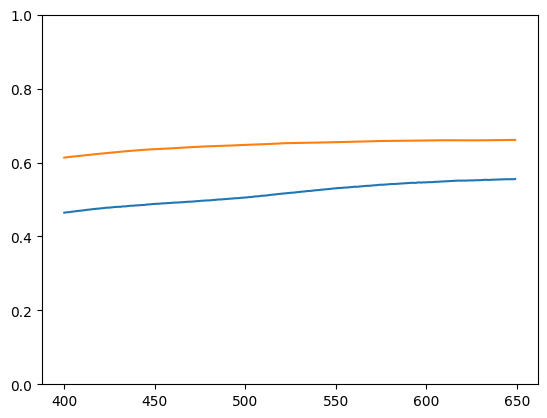

In [27]:
from transfer_matrix_method import reflectance
from transfer_matrix_method.reflectance import Layer
from transfer_matrix_method.refractive_index import MaterialRefractiveIndex
import matplotlib.pyplot as plt

spec = [10,10,10,20,20,20, *materials_to_use[::-1]]

layers = [Layer(t*1e-9, MaterialRefractiveIndex(materials[spec[6:][i%2]])) for i,t in enumerate(spec[:6])]

x = np.arange(400,650,1)
y1 = ml_model.predict([spec]).T
y2 = [reflectance(layers,x_i*1e-9)["reflectance"] for x_i in x]

fig,ax = plt.subplots()

ax.plot(x,list(zip(y1,y2)))
ax.set_ylim(0,1)